In [1]:
!pip install git+https://github.com/adil3319/jim
#!pip install jimGW

  Cloning https://github.com/adil3319/jim to /tmp/pip-req-build-42bmacx1
  Running command git clone --filter=blob:none --quiet https://github.com/adil3319/jim /tmp/pip-req-build-42bmacx1
  Resolved https://github.com/adil3319/jim to commit e0cb39531a90adca4802ddaaf5c3513c87e9e379
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
INFO: pip is looking at multiple versions of flowmc to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of equinox to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of evosax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of flax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is

In [2]:
# For CUDA 12 with cuDNN 8.9
!pip install --upgrade "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.8/15.8 MB 103.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.3/124.3 MB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 MB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 102.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 92.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 MB 57.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 706.8/706.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.7/90.7 MB 23.1 MB/s eta 0:00:00
  Attempting uninstall: jax-cuda12-pjrt
    Found existing installation: jax-cuda12-pjrt 0.5.1
    Uninstalling jax-cuda12-pjrt-0.5.1:
      Successfully uninstalled jax-cuda12-pjrt-0.5.1
  Attempting uninstall: nvidia-cudnn-cu12
    Found existing installation: nvidia-cudnn-cu12 9

In [3]:
!pip install --upgrade equinox

  Using cached equinox-0.12.2-py3-none-any.whl.metadata (18 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.2/177.2 kB 4.1 MB/s eta 0:00:00
  Attempting uninstall: equinox
    Found existing installation: equinox 0.11.10
    Uninstalling equinox-0.11.10:
      Successfully uninstalled equinox-0.11.10


In [4]:
import numpy as np
import jax.numpy as jnp

In [5]:
import time

import jax
#jax.config.update("jax_debug_nans", True)
import jax.numpy as jnp

from jimgw.jim import Jim
from jimgw.prior import *
#from jimgw.jim import Jim
# from jimgw.prior import (
#     CombinePrior,
#     UniformPrior,
#     CosinePrior,
#     SinePrior,
#     PowerLawPrior,
#     UniformSpherePrior,
# )
from jimgw.single_event.detector import H1, L1, V1
from jimgw.single_event.likelihood import TransientLikelihoodFD, HeterodynedTransientLikelihoodFD
from jimgw.single_event.waveform import RippleIMRPhenomD,RippleIMRPhenomD_NRTidalv2,RippleTaylorF2
from jimgw.transforms import BoundToUnbound
from jimgw.single_event.transforms import (
    SkyFrameToDetectorFrameSkyPositionTransform,
    SphereSpinToCartesianSpinTransform,
    MassRatioToSymmetricMassRatioTransform,
    DistanceToSNRWeightedDistanceTransform,
    GeocentricArrivalTimeToDetectorArrivalTimeTransform,
    GeocentricArrivalPhaseToDetectorArrivalPhaseTransform,
)
from jimgw.single_event.utils import Mc_q_to_m1_m2
from flowMC.strategy.optimization import optimization_Adam

jax.config.update("jax_enable_x64", True)

###########################################
########## First we grab data #############
###########################################

total_time_start = time.time()

# first, fetch a 4s segment centered on GW150914

ifos = [H1, L1, V1]


# tukey_alpha = 2 / (duration / 2)
# H1.load_data(
#     gps, duration, 2, fmin, fmax, psd_pad=duration + 16, tukey_alpha=tukey_alpha
# )
# L1.load_data(
#     gps, duration, 2, fmin, fmax, psd_pad=duration + 16, tukey_alpha=tukey_alpha
# )
# V1.load_data(
#     gps, duration, 2, fmin, fmax, psd_pad=duration + 16, tukey_alpha=tukey_alpha
# )

H1.frequencies = np.genfromtxt('H1_freq.txt')
H1_data_re, H1_data_im = np.genfromtxt('H1_data_re.txt'), np.genfromtxt('H1_data_im.txt')
H1.data = H1_data_re + 1j * H1_data_im
H1_jnp = jax.numpy.array(H1.frequencies)

L1.frequencies = np.genfromtxt('L1_freq.txt')
L1_data_re, L1_data_im = np.genfromtxt('L1_data_re.txt'), np.genfromtxt('L1_data_im.txt')
L1.data = L1_data_re + 1j * L1_data_im
L1_jnp = jax.numpy.array(L1.frequencies)

V1.frequencies = np.genfromtxt('V1_freq.txt')
V1_data_re, V1_data_im = np.genfromtxt('V1_data_re.txt'), np.genfromtxt('V1_data_im.txt')
V1.data = V1_data_re + 1j * V1_data_im
V1_jnp = jax.numpy.array(V1.frequencies)
# Load the PSD

H1.psd = H1.load_psd(H1_jnp, psd_file ="GW170817-IMRD_data0_1187008882-43_generation_data_dump.pickle_H1_psd.txt")
L1.psd = L1.load_psd(L1_jnp, psd_file = "GW170817-IMRD_data0_1187008882-43_generation_data_dump.pickle_L1_psd.txt")
V1.psd = V1.load_psd(V1_jnp, psd_file = "GW170817-IMRD_data0_1187008882-43_generation_data_dump.pickle_V1_psd.txt")





In [6]:
len(H1.data),len(H1.psd),len(H1.frequencies),len(L1.psd),len(L1.frequencies),len(V1.psd),len(V1.frequencies)

(259583, 259583, 259583, 259583, 259583, 259583, 259583)

##  WAVEFORM MODEL

In [7]:
from abc import ABC

import jax.numpy as jnp
from jaxtyping import Array, Float
from ripplegw.waveforms.IMRPhenomD import gen_IMRPhenomD_hphc

In [8]:
class Waveform(ABC):
    def __init__(self):
        return NotImplemented

    def __call__(
        self, axis: Float[Array, " n_dim"], params: dict[str, Float]
    ) -> dict[str, Float[Array, " n_dim"]]:
        return NotImplemented


In [9]:
import numpy as np

# H1 frequency masking
ah = H1.frequencies
bh = H1.data
ch = H1.psd

# Find the indices where any of the arrays contains inf
mask = np.isinf(ah) | np.isinf(bh) | np.isinf(ch)

# Remove the elements where the mask is True
H1.frequencies = ah[~mask][:-1]
H1.data = bh[~mask][:-1]
H1.psd = ch[~mask][:-1]



# L1 frequency masking
aL = L1.frequencies
bL = L1.data
cL = L1.psd

# Find the indices where any of the arrays contains inf
mask = np.isinf(aL) | np.isinf(bL) | np.isinf(cL)

# Remove the elements where the mask is True
L1.frequencies = aL[~mask]
L1.data = bL[~mask]
L1.psd = cL[~mask]


# V1 frequency masking
aV = V1.frequencies
bV = V1.data
cV = V1.psd

# Find the indices where any of the arrays contains inf
mask = np.isinf(aV) | np.isinf(bV) | np.isinf(cV)

# Remove the elements where the mask is True
V1.frequencies = aV[~mask]
V1.data = bV[~mask]
V1.psd = cV[~mask]





gps = 1187008882.43
trigger_time = gps
fmin = min(H1.frequencies)
fmax = max(H1.frequencies)
#fmax = 2048
minimum_frequency = fmin
maximum_frequency = fmax
duration = 128
post_trigger_duration = 2
epoch = duration - post_trigger_duration
f_ref = fmin


#RippleIMRPhenomD_NRTidalv2(f_ref=f_ref)


In [10]:
class RippleIMRPhenomD_MGR(Waveform):
    f_ref: float

    def __init__(self, f_ref: float = fmin, **kwargs):
        self.f_ref = f_ref

    def __call__(
        self, frequency: Float[Array, " n_dim"], params: dict[str, Float]
    ) -> dict[str, Float[Array, " n_dim"]]:
        output = {}
        theta = jnp.array(
            [
                params["M_c"],
                params["eta"],
                params["s1_z"],
                params["s2_z"],
                params["d_L"],
                0,
                params["phase_c"],
                params["iota"],
               # params["alpha"],
                params["beta"]
            ]
        )
        hp, hc = gen_IMRPhenomD_hphc(frequency, theta, self.f_ref)
        cf =1.4765e3
        c=2.998e8
        u=(jnp.pi*(theta[0]/theta[1]**0.6)*frequency*cf/c)**(1/3) # cf =1.4765e3 m
        a,b=-2,-7
       # hpT = hp*(1+theta[-2]*u**a)*jnp.exp(1.0j*theta[-1]*u**b)
       # hcT = hc*(1+theta[-2]*u**a)*jnp.exp(1.0j*theta[-1]*u**b)
        hpT = hp*jnp.exp(1.0j*theta[-1]*u**b)
        hcT = hc*jnp.exp(1.0j*theta[-1]*u**b)
        output["p"] = hpT
        output["c"] = hcT
        return output


    def __repr__(self):
        return f"RippleIMRPhenomD_MGR(f_ref={self.f_ref})"

waveform = RippleIMRPhenomD_MGR(f_ref=f_ref)

In [11]:
len(H1.data),len(H1.psd),len(H1.frequencies),len(L1.psd),len(L1.frequencies),len(V1.psd),len(V1.frequencies)

(259199, 259199, 259199, 259199, 259199, 259199, 259199)

In [12]:
min(H1.frequencies),min(L1.frequencies),min(V1.frequencies),max(H1.frequencies),max(L1.frequencies),max(V1.frequencies)

(np.float64(23.0),
 np.float64(23.0),
 np.float64(23.0),
 np.float64(2047.984375),
 np.float64(2047.984375),
 np.float64(2047.984375))

In [13]:
fmin,fmax

(np.float64(23.0), np.float64(2047.984375))

In [14]:
import numpy as np

# Example array


# Check if there are any inf values in a
contains_inf = np.any(np.isinf(H1.psd))

if contains_inf:
    print("Array contains inf values.")
else:
    print("Array does not contain inf values.")


Array does not contain inf values.


In [15]:
###########################################
########## Set up priors ##################
###########################################
import time
t1 = time.time()
prior = []

# Mass prior
M_c_min, M_c_max = 1.18, 1.21
q_min, q_max = 0.125, 1.0
Mc_prior = UniformPrior(M_c_min, M_c_max, parameter_names=["M_c"])
q_prior = UniformPrior(q_min, q_max, parameter_names=["q"])

prior = prior + [Mc_prior, q_prior]

# Spin prior
s1_prior = UniformPrior(-0.05, 0.05, parameter_names=["s1_z"])
s2_prior = UniformPrior(-0.05, 0.05, parameter_names=["s2_z"])
iota_prior = SinePrior(parameter_names=["iota"])

prior = prior + [
    s1_prior,
    s2_prior,
    iota_prior,
]

# Extrinsic prior
dL_prior = UniformPrior(1.0, 75.0, parameter_names=["d_L"])
t_c_prior = UniformPrior(-0.1, 0.1, parameter_names=["t_c"])
phase_c_prior = UniformPrior(0.0, 2 * jnp.pi, parameter_names=["phase_c"])
#lambda_1_prior =UniformPrior(0.0, 5000.0, parameter_names=["lambda_1"])
#lambda_2_prior = UniformPrior(0.0, 5000.0, parameter_names=["lambda_2"])
psi_prior = UniformPrior(0.0, jnp.pi, parameter_names=["psi"])
ra_prior = UniformPrior(0.0, 2 * jnp.pi, parameter_names=["ra"])
dec_prior =CosinePrior(parameter_names=["dec"])

#alpha_prior = GaussianPrior(0.0, 0.01, parameter_names=["alpha"])
beta_prior = UniformPrior(-0.1, 0.1, parameter_names=["beta"])

prior = prior + [
    dL_prior,
    t_c_prior,
    phase_c_prior,
   #lambda_1_prior,
   #lambda_2_prior,
    psi_prior,
    ra_prior,
    dec_prior,
   # alpha_prior,
   # beta_prior
]

prior = CombinePrior(prior)

# The following only works if every prior has xmin and xmax property, which is OK for Uniform and Powerlaw
# bounds = jnp.array([[p.xmin, p.xmax] for p in prior.priors])

# Defining Transforms

sample_transforms = [
    DistanceToSNRWeightedDistanceTransform(gps_time=gps, ifos=ifos, dL_min=dL_prior.xmin, dL_max=dL_prior.xmax),
    GeocentricArrivalPhaseToDetectorArrivalPhaseTransform(gps_time=gps, ifo=ifos[0]),
    GeocentricArrivalTimeToDetectorArrivalTimeTransform(tc_min=t_c_prior.xmin, tc_max=t_c_prior.xmax, gps_time=gps, ifo=ifos[0]),
    SkyFrameToDetectorFrameSkyPositionTransform(gps_time=gps, ifos=ifos),
    BoundToUnbound(name_mapping = (["M_c"], ["M_c_unbounded"]), original_lower_bound=M_c_min, original_upper_bound=M_c_max),
    BoundToUnbound(name_mapping = (["q"], ["q_unbounded"]), original_lower_bound=q_min, original_upper_bound=q_max),
    #BoundToUnbound(name_mapping = (["lambda_1"], ["lambda_1_unbounded"]), original_lower_bound=0.0, original_upper_bound=5000.0),
    #BoundToUnbound(name_mapping = (["lambda_2"], ["lambda_2_unbounded"]), original_lower_bound=0.0, original_upper_bound=5000.0),
    BoundToUnbound(name_mapping = (["s1_z"], ["s1_z_unbounded"]) , original_lower_bound=-0.05, original_upper_bound=0.05),
    BoundToUnbound(name_mapping = (["s2_z"], ["s2_z_unbounded"]) , original_lower_bound=-0.05, original_upper_bound=0.05),
    BoundToUnbound(name_mapping = (["iota"], ["iota_unbounded"]) , original_lower_bound=0.0, original_upper_bound=jnp.pi),
    BoundToUnbound(name_mapping = (["phase_det"], ["phase_det_unbounded"]), original_lower_bound=0.0, original_upper_bound=2 * jnp.pi),
    BoundToUnbound(name_mapping = (["psi"], ["psi_unbounded"]), original_lower_bound=0.0, original_upper_bound=jnp.pi),
    BoundToUnbound(name_mapping = (["zenith"], ["zenith_unbounded"]), original_lower_bound=0.0, original_upper_bound=jnp.pi),
    BoundToUnbound(name_mapping = (["azimuth"], ["azimuth_unbounded"]), original_lower_bound=0.0, original_upper_bound=2 * jnp.pi),
    #BoundToUnbound(name_mapping = (["beta"], ["beta_unbounded"]) , original_lower_bound=-0.1, original_upper_bound=0.1)
    ]


likelihood_transforms = [
    MassRatioToSymmetricMassRatioTransform,
]
ref_params = {
   'M_c': 1.1975896,
   'eta': 0.2461001,
   's1_z': -2.96672676e-02,
   's2_z': 2.80404568e-02,
   #'lambda_1': 791.04366468,
   #'lambda_2': 891.04366468,
   'd_L': 42.86331818,
   't_c': -5.93548230e-05,
   'phase_c': 4.58680356e+00,
   'iota': 2.85,
   'psi': 3.14,
   'ra': 3.44536826,
   'dec': -0.408082,
  # 'alpha':0.0,
 #  'beta':0.0
}
param_names = prior.parameter_names
print(param_names)

likelihood = HeterodynedTransientLikelihoodFD(ifos,ref_params = ref_params,fixing_parameters={'beta':0.0}, waveform=waveform, n_bins = 1000, trigger_time=trigger_time, duration=duration, post_trigger_duration=post_trigger_duration, prior = prior , likelihood_transforms = likelihood_transforms, popsize = 50, n_steps = 1000)


['M_c', 'q', 's1_z', 's2_z', 'iota', 'd_L', 't_c', 'phase_c', 'psi', 'ra', 'dec']
Initializing heterodyned likelihood..
Parameters are fixed {'beta': 0.0}
Reference parameters provided, which are {'M_c': 1.1975896, 'eta': 0.2461001, 's1_z': -0.0296672676, 's2_z': 0.0280404568, 'd_L': 42.86331818, 't_c': -5.9354823e-05, 'phase_c': 4.58680356, 'iota': 2.85, 'psi': 3.14, 'ra': 3.44536826, 'dec': -0.408082}
Constructing reference waveforms..


In [16]:


eps = 1e-3
n_dim = 11 #13
mass_matrix = jnp.eye(n_dim)
#mass_matrix = mass_matrix.at[0,0].set(1e-5)
#mass_matrix = mass_matrix.at[1,1].set(1e-4)
#mass_matrix = mass_matrix.at[2,2].set(1e-3)
#mass_matrix = mass_matrix.at[3,3].set(1e-3)
#mass_matrix = mass_matrix.at[5,5].set(1e-5) #mass_matrix = mass_matrix.at[7,7].set(1e-5)
#mass_matrix = mass_matrix.at[9,9].set(1e-2)#mass_matrix = mass_matrix.at[11,11].set(1e-2)
#mass_matrix = mass_matrix.at[10,10].set(1e-2)#mass_matrix = mass_matrix.at[12,12].set(1e-2)
local_sampler_arg = {"step_size": mass_matrix * eps}

Adam_optimizer = optimization_Adam(n_steps=3000, learning_rate=0.01, noise_level=1)

import optax

n_loop_training = 50
n_epochs = 20
total_epochs = n_epochs * n_loop_training
start = int(total_epochs / 10)
start_lr = 1e-3
end_lr = 1e-5
power = 4.0
schedule_fn = optax.polynomial_schedule(
    start_lr, end_lr, power, total_epochs-start, transition_begin=start)

scheduler_str = f"polynomial_schedule({start_lr}, {end_lr}, {power}, {total_epochs-start}, {start})"

# Choose between fixed learning rate - or - the above scheduler here

# learning_rate = 1e-3
learning_rate = schedule_fn

jim = Jim(
    likelihood,
    prior,
    sample_transforms=sample_transforms,
    likelihood_transforms=likelihood_transforms,
    n_loop_training=n_loop_training,
    n_loop_production=20,
    n_local_steps=300,
    n_global_steps=500,
    n_chains=5000,
    n_epochs =n_epochs,
    learning_rate=learning_rate,
    n_max_examples=30000,
    n_flow_sample=50000,
    momentum=0.9,
    batch_size=50000,
    use_global=True,
    keep_quantile=0.0,
    train_thinning=50,
    output_thinning=50,
    local_sampler_arg=local_sampler_arg,
    stopping_criterion_global_acc = 0.2
    #strategies=[Adam_optimizer,"default"],
)
jim.sample(jax.random.PRNGKey(42))
jim.print_summary()
t2 = time.time()
print((t2-t1)/3600)

Using sample transforms
['n_dim', 'n_chains', 'n_local_steps', 'n_global_steps', 'n_loop', 'output_thinning', 'verbose']


Global Tuning:   0%|          | 0/50 [00:00<?, ?it/s]

Compiling MALA body


Global Sampling: 100%|██████████| 20/20 [07:32<00:00, 22.65s/it]


Training summary
M_c: 1.197 +/- 0.002
d_L: 46.436 +/- 12.023
dec: -0.242 +/- 0.482
iota: 2.150 +/- 0.815
phase_c: 3.090 +/- 1.800
psi: 1.454 +/- 0.884
q: 0.690 +/- 0.127
ra: 3.209 +/- 1.039
s1_z: 0.015 +/- 0.024
s2_z: -0.000 +/- 0.026
t_c: 0.006 +/- 0.016
Log probability: 380.297 +/- 1781.870
Local acceptance: 0.316 +/- 0.465
Global acceptance: 0.001 +/- 0.038
Max loss: 22.629, Min loss: 7.265
Production summary
M_c: 1.197 +/- 0.000
d_L: 38.064 +/- 4.758
dec: -0.351 +/- 0.053
iota: 2.587 +/- 0.237
phase_c: 3.099 +/- 1.808
psi: 1.477 +/- 0.889
q: 0.698 +/- 0.079
ra: 3.414 +/- 0.089
s1_z: 0.021 +/- 0.019
s2_z: 0.003 +/- 0.025
t_c: 0.000 +/- 0.001
Log probability: 532.338 +/- 2.962
Local acceptance: 0.157 +/- 0.364
Global acceptance: 0.000 +/- 0.021
0.6000647129615148


In [17]:
1.0372118015090304e-22

1.0372118015090304e-22

In [18]:
# prior_range = jnp.array([[1.18,1.21],[0.125,1],[-0.05,0.05],[-0.05,0.05],[2.5,2.9],[1.0,75.0],[-0.01,0.01],[0,2*np.pi],[0.0, np.pi],[3.38,3.48],[-0.420,-0.38],[-0.1,0.1]])

# from scipy.optimize import minimize
# def neg_log_likelihood1(x):
#     param_dict = dict(zip(param_names, x))

#    # Convert 'q' to 'eta'
#     if 'q' in param_dict:
#         q = param_dict.pop('q')
#         eta = q / (1 + q)**2
#         param_dict['eta'] = eta
#     return likelihood1.evaluate_original(param_dict, data={})
# f1 = jax.jit(neg_log_likelihood1)
# y1 = lambda x:-f1(x)
# x0 = np.mean(np.array(prior_range), axis=1)

# # Run the optimizer (method can be 'L-BFGS-B', 'Powell', etc.)
# result = minimize(
#     fun=y1,
#     x0=x0,
#     bounds=prior_range,
#     method='SLSQP',  # Good general-purpose method with bounds
#     options={'disp': True}
# )

# # Extract best-fit parameters
# ref_params = dict(zip(param_names, result.x))
# print("Best-fit parameters:")
# for k, v in ref_params.items():
#     print(f"{k}: {v:.5f}")
# # import sys
# # sys.exit()

In [19]:
# ref_params = {
#    'M_c': 1.1972896,
#    'eta': 0.2461001,
#    's1_z': -2.96672676e-02,
#    's2_z': 2.80404568e-02,
#    #'lambda_1': 791.04366468,
#    #'lambda_2': 891.04366468,
#    'd_L': 42.86331818,
#    't_c': -5.93548230e-05,
#    'phase_c': 4.58680356e+00,
#    'iota': 2.85,
#    'psi': 3.14,
#    'ra': 3.44536826,
#    'dec': -0.408082,
#   # 'alpha':0.0,
#    'beta':1e-5
# }
# likelihood_value = likelihood1.evaluate_original(ref_params, data={})
# print("Likelihood at reference parameters:", likelihood_value)


In [20]:

# # Minimize the *negative* log likelihood
# def neg_log_likelihood(x):
#     param_dict = dict(zip(param_names, x))

#    # Convert 'q' to 'eta'
#     if 'q' in param_dict:
#         q = param_dict.pop('q')
#         eta = q / (1 + q)**2
#         param_dict['eta'] = eta
#     return likelihood1.evaluate_original(param_dict, data={})

# f = jax.jit(neg_log_likelihood)
# y = lambda x:-f(x)

# # Run the optimizer
# result = differential_evolution(y, prior_range)
# ref_params = dict(zip(prior.parameter_names, result.x))

# print("Reference parameters from DE:", ref_params)
# import sys
# sys.exit()


In [21]:
samples=jim.get_samples()

In [22]:
import pandas as pd

df = pd.DataFrame(samples)

# Save the DataFrame to a CSV file
df.to_csv('GW170817_MGR_11_uniform.csv', index=False)

In [23]:
import numpy as np
#import corner
samples = jim.get_samples()
DL = np.array(samples["d_L"])
np.median(DL),np.std(DL)

(np.float64(38.411596974626654), np.float64(4.758360177326716))

<ipython-input-24-90755900>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(DL)


<Axes: ylabel='Density'>

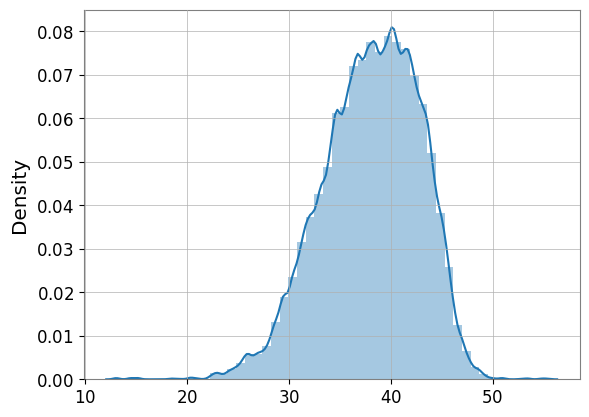

In [24]:
import seaborn as sns
sns.distplot(DL)

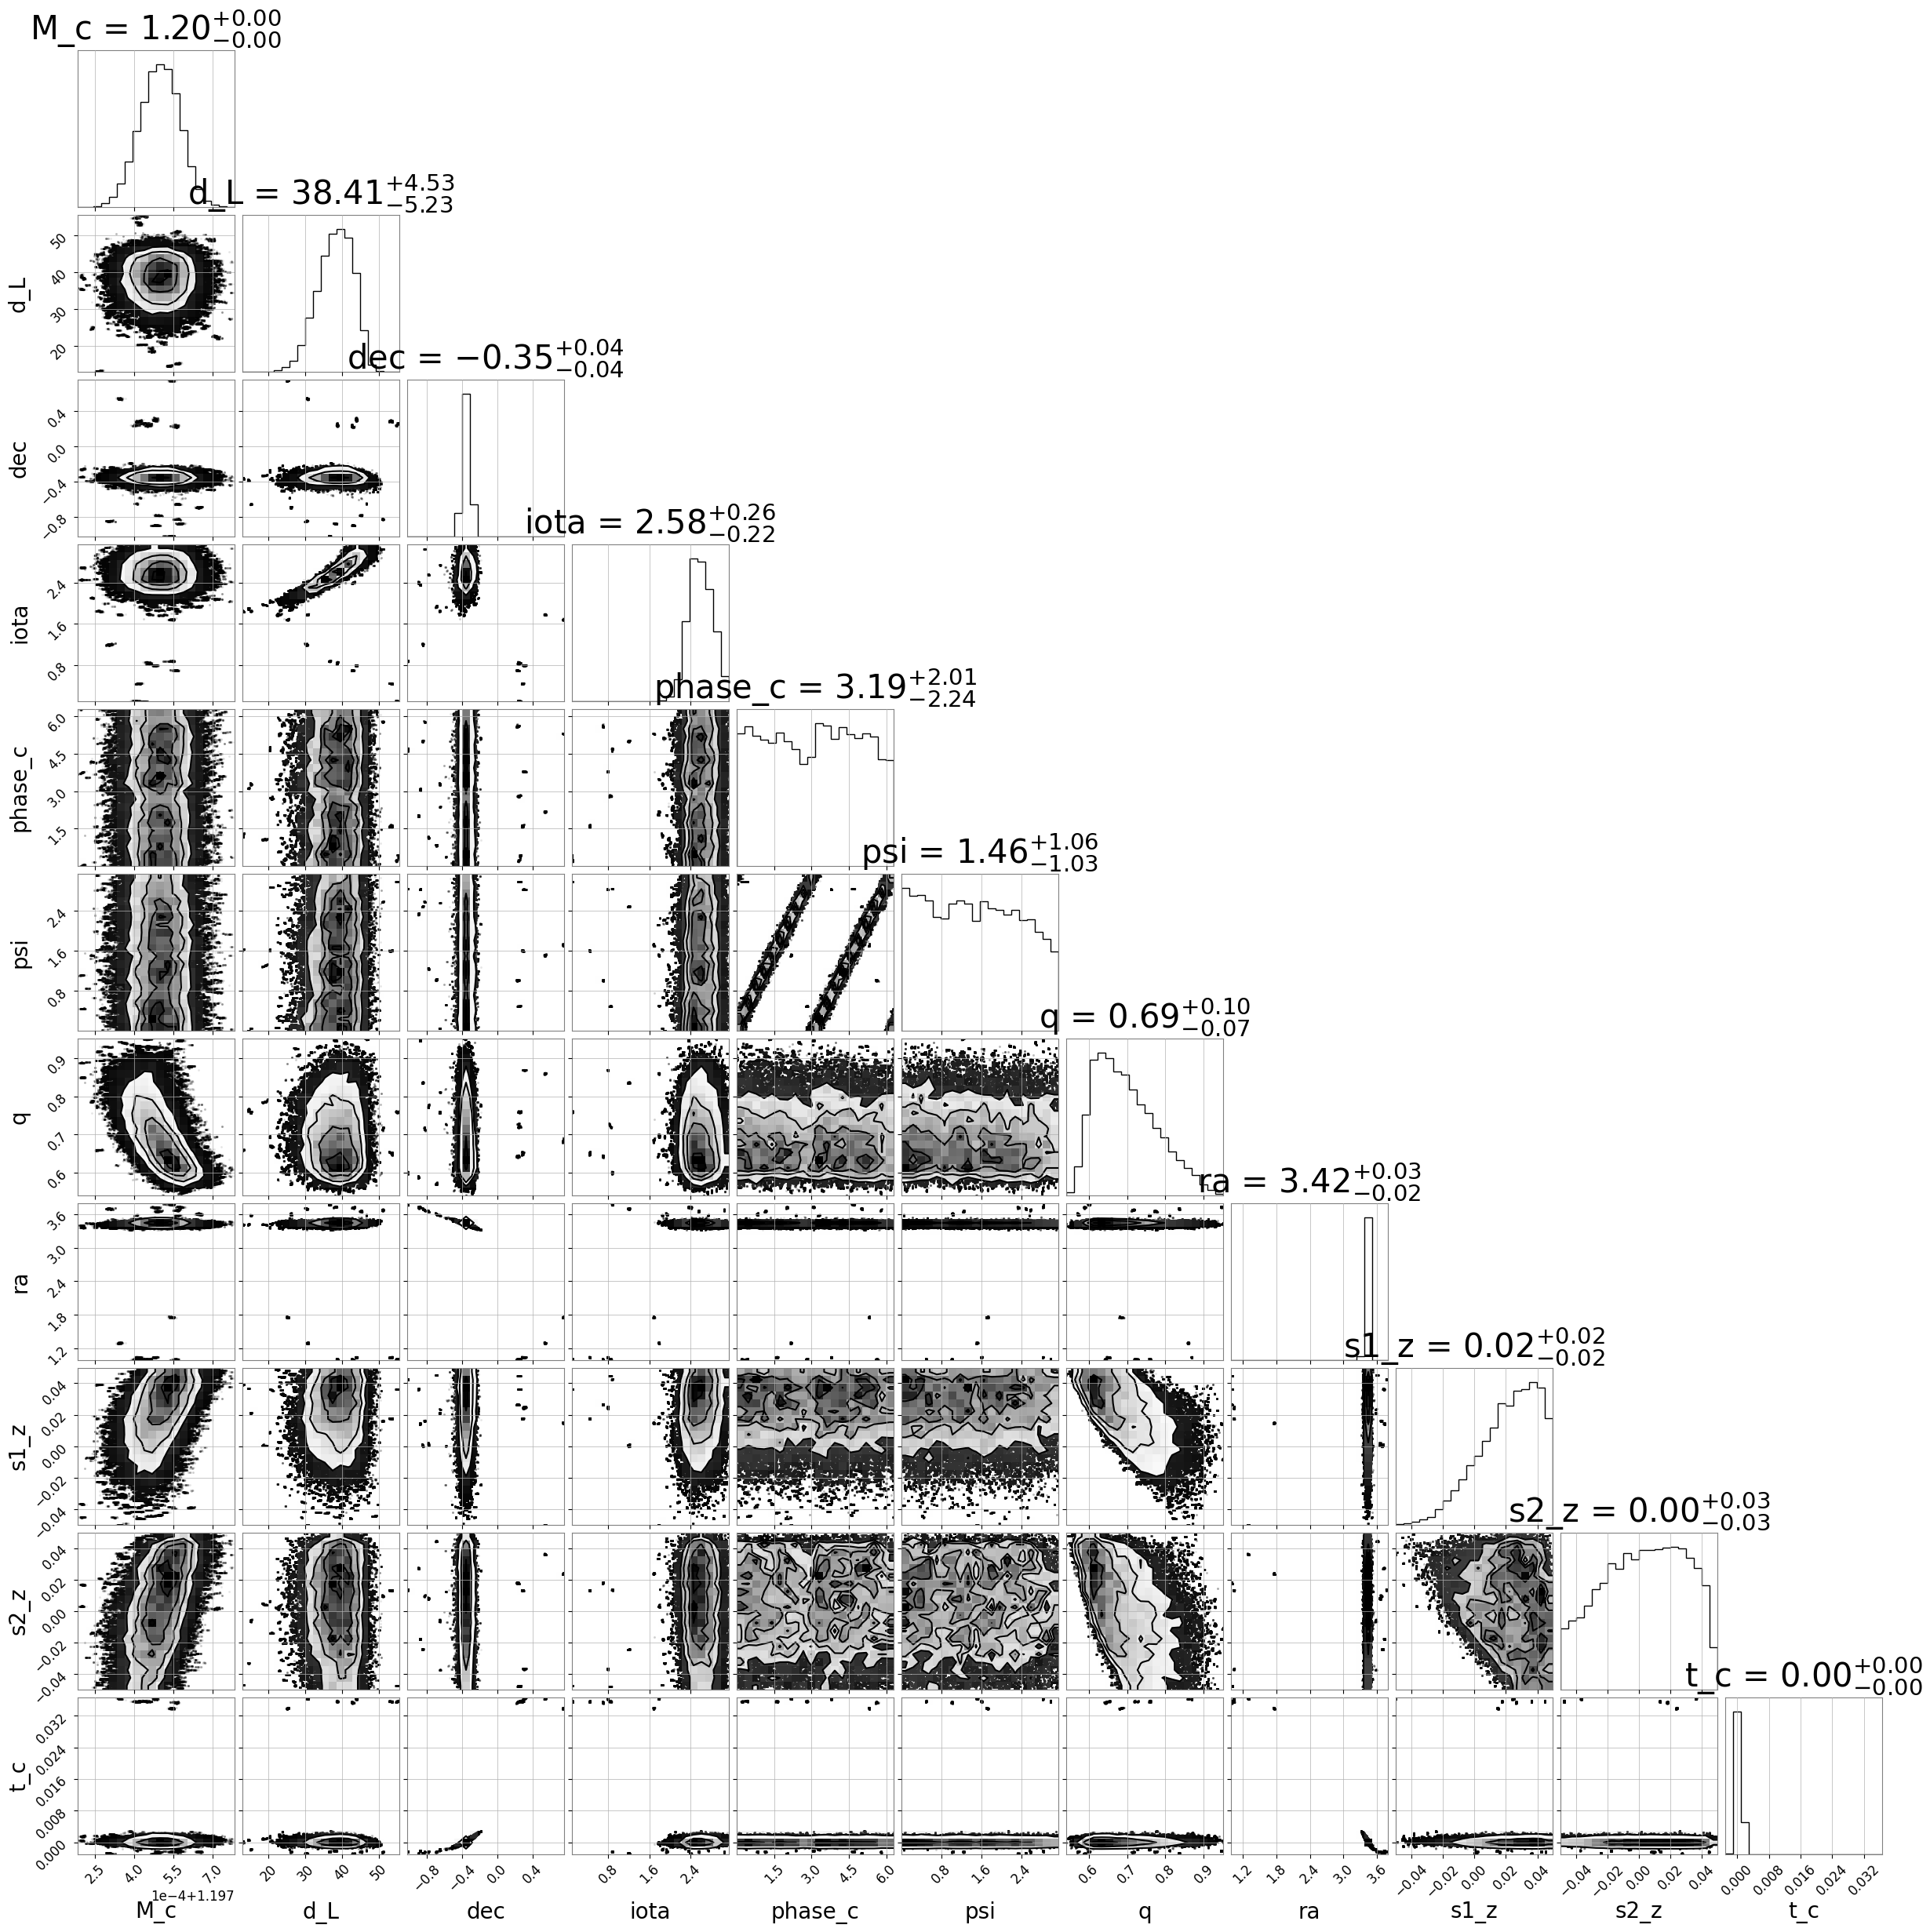

In [25]:
import corner
import numpy as np
import matplotlib.pyplot as plt
data = np.vstack([value for value in samples.values()]).T

# Create corner plot
fig = corner.corner(data, labels=list(samples.keys()),title_kwargs={'fontsize': 30},  # Increase title font size
    label_kwargs={'fontsize': 20}, show_titles=True)
plt.savefig("GW170817_MGR_beta=0.pdf")
# Show the plot
plt.show()

In [26]:
jim.print_summary()

Training summary
M_c: 1.197 +/- 0.002
d_L: 46.436 +/- 12.023
dec: -0.242 +/- 0.482
iota: 2.150 +/- 0.815
phase_c: 3.090 +/- 1.800
psi: 1.454 +/- 0.884
q: 0.690 +/- 0.127
ra: 3.209 +/- 1.039
s1_z: 0.015 +/- 0.024
s2_z: -0.000 +/- 0.026
t_c: 0.006 +/- 0.016
Log probability: 380.297 +/- 1781.870
Local acceptance: 0.316 +/- 0.465
Global acceptance: 0.001 +/- 0.038
Max loss: 22.629, Min loss: 7.265
Production summary
M_c: 1.197 +/- 0.000
d_L: 38.064 +/- 4.758
dec: -0.351 +/- 0.053
iota: 2.587 +/- 0.237
phase_c: 3.099 +/- 1.808
psi: 1.477 +/- 0.889
q: 0.698 +/- 0.079
ra: 3.414 +/- 0.089
s1_z: 0.021 +/- 0.019
s2_z: 0.003 +/- 0.025
t_c: 0.000 +/- 0.001
Log probability: 532.338 +/- 2.962
Local acceptance: 0.157 +/- 0.364
Global acceptance: 0.000 +/- 0.021


In [27]:
import numpy as np
import arviz as az



# Step 1: Reshape the samples to simulate multiple chains (assuming 2 chains)
# We split the long array into 2 chains. Adjust the shape as needed.
num_chains = 2
num_iterations = len(samples['M_c']) // num_chains  # Total samples / number of chains

samples_reshaped = {param: np.reshape(sample, (num_chains, num_iterations)) for param, sample in samples.items()}

# Step 2: Convert to Arviz InferenceData format
inference_data = az.from_dict(posterior=samples_reshaped)

# Step 3: Calculate Gelman-Rubin (Rhat)
rhat_values = az.rhat(inference_data)
print("Gelman-Rubin (Rhat) Values:\n", rhat_values)

# Step 4: Calculate Effective Sample Size (ESS)
ess_values = az.ess(inference_data)
print("\nEffective Sample Size (ESS):\n", ess_values)

# Optional: Visualize trace and autocorrelation plots
# az.plot_trace(inference_data)
# az.plot_autocorr(inference_data)


Gelman-Rubin (Rhat) Values:
 <xarray.Dataset> Size: 88B
Dimensions:  ()
Data variables:
    M_c      float64 8B 1.0
    d_L      float64 8B 1.0
    dec      float64 8B 1.001
    iota     float64 8B 1.0
    phase_c  float64 8B 1.0
    psi      float64 8B 1.0
    q        float64 8B 1.0
    ra       float64 8B 1.0
    s1_z     float64 8B 1.001
    s2_z     float64 8B 1.0
    t_c      float64 8B 1.0

Effective Sample Size (ESS):
 <xarray.Dataset> Size: 88B
Dimensions:  ()
Data variables:
    M_c      float64 8B 9.838e+03
    d_L      float64 8B 9.159e+03
    dec      float64 8B 1.044e+04
    iota     float64 8B 9.165e+03
    phase_c  float64 8B 1.119e+04
    psi      float64 8B 9.697e+03
    q        float64 8B 8.616e+03
    ra       float64 8B 1.081e+04
    s1_z     float64 8B 8.897e+03
    s2_z     float64 8B 9.343e+03
    t_c      float64 8B 1.065e+04
